### **About**: The Notebook contains the model training pipeline for the ePRO system described in the paper. It reads the encoded data from the google drive and trains a bunch of Models. The Final section of the notebook contains the model testing results for new participants which is addressed in the paper as 'Robustness Testing and Performance on Cold Start Scenarios'

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [2]:
from tabulate import tabulate
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Step 1: Define the directory path where the CSV files are located
csv_directory = '/content/drive/MyDrive/epro_project_data/client/encoded_data'

# Step 2: Initialize an empty list to store the DataFrames
dfs = []

# Step 3: Get a list of CSV files in the directory
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

# Step 4: Loop through each CSV file, read it, and store it as a DataFrame
for file in csv_files:
    file_path = os.path.join(csv_directory, file)
    df = pd.read_csv(file_path)
    dfs.append(df)

# Step 5: Concatenate all the DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

In [5]:
merged_df['class'].value_counts()

1    14705
0     6624
Name: class, dtype: int64

In [6]:
6625/14712

0.4503126699293094

In [6]:
merged_df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,class
count,21329.000000,21329.0,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000,21329.000000
mean,7.130780,0.0,3.734975,5.947613,0.204471,3.669937,5.540511,4.309179,4.223438,3.009844,0.689437
std,2.947524,0.0,1.993140,3.551394,0.617342,1.929441,3.217020,1.976067,1.573288,1.431684,0.462735
min,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.115044,0.0,2.504679,3.336536,0.000000,1.941107,3.165383,2.873074,3.105397,1.961536,0.000000
50%,7.265044,0.0,3.663004,5.014012,0.000000,3.901527,4.732820,4.252754,4.231185,2.823824,1.000000
75%,9.259109,0.0,4.957042,8.189354,0.000000,5.070973,7.100858,5.673274,5.340866,3.912064,1.000000
max,14.686796,0.0,9.942740,19.308496,6.278288,9.314926,17.026620,10.536957,9.154533,8.921324,1.000000


In [7]:
X = merged_df.drop(columns=['researchParticipantId', 'class'])
y = merged_df['class']

## Model 1: Logistic Regression with Encoded Features

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Using StratifiedKFold for cross-validation with 'cv' number of folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Logistic Regression model with class_weight='balanced'
logreg_model = LogisticRegression(class_weight='balanced', random_state=42)

# Initialize lists to store AUC-PR scores and confusion matrices for each fold
cv_scores = []
confusion_matrices = []

# Initialize an empty list to store predicted probabilities for all folds
y_probas_all_folds = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    logreg_model.fit(X_train, y_train)
    y_probas = logreg_model.predict_proba(X_test)[:, 1]

    # Append predicted probabilities for this fold to the list
    y_probas_all_folds.extend(y_probas)

    cv_scores.append(average_precision_score(y_test, y_probas))
    y_pred = logreg_model.predict(X_test)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Calculate the mean AUC-PR score across all folds
mean_auc_pr = np.mean(cv_scores)

# Find the best threshold that maximizes the mean AUC-PR score
precision, recall, thresholds = precision_recall_curve(y, y_probas_all_folds)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

# Display the tabular view of results
results_df = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'AUC-PR Score': cv_scores,
    'Confusion Matrix': confusion_matrices
})

results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: '\n'.join([' '.join(map(str, row)) for row in x]))

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Mean AUC-PR: {mean_auc_pr:.4f}")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))




Best Threshold: 0.3289
Mean AUC-PR: 0.7276
+--------+----------------+--------------------+
|   Fold |   AUC-PR Score | Confusion Matrix   |
+========+================+====================+
|      1 |       0.718602 | 641 684            |
|        |                | 1231 1710          |
+--------+----------------+--------------------+
|      2 |       0.731832 | 670 655            |
|        |                | 1185 1756          |
+--------+----------------+--------------------+
|      3 |       0.731067 | 650 675            |
|        |                | 1180 1761          |
+--------+----------------+--------------------+
|      4 |       0.732535 | 657 668            |
|        |                | 1174 1767          |
+--------+----------------+--------------------+
|      5 |       0.723744 | 638 686            |
|        |                | 1172 1769          |
+--------+----------------+--------------------+


In [9]:
auc_pr_logreg=cv_scores

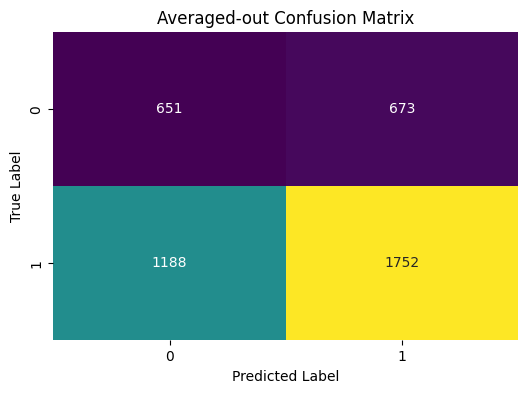

In [10]:
# Plot the averaged-out confusion matrix with improved color palette
conf_matrix_avg = np.mean(confusion_matrices, axis=0).astype(int)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Averaged-out Confusion Matrix')
plt.show()



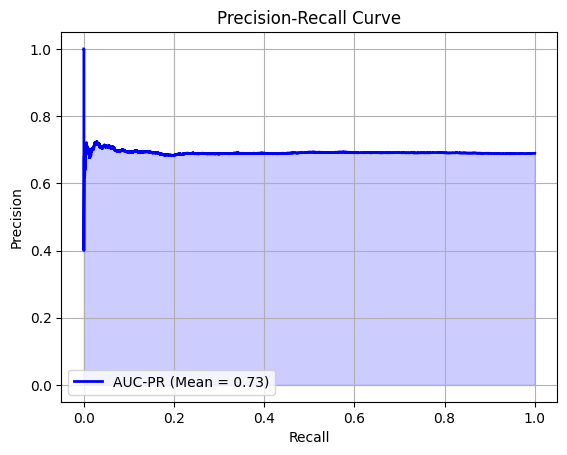

In [11]:
# Plot the precision-recall curve
plt.plot(recall, precision, color='b', lw=2, label=f'AUC-PR (Mean = {mean_auc_pr:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [17]:
model_filename = '/content/drive/MyDrive/epro_project_data/classification_models/logreg_encoder_model_v1.pkl'
joblib.dump(logreg_model, model_filename)


['/content/drive/MyDrive/epro_project_data/classification_models/logreg_encoder_model_v1.pkl']

## Model 2: XgBoost Model with Encoded Features

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Using StratifiedKFold for cross-validation with 'cv' number of folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the XGBoost model with class_weight='balanced' and AUC-PR as the evaluation metric
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=0.498,
    reg_alpha=2.8,
    reg_lambda=4.3,
    learning_rate=0.01,
    n_estimators=910,
    max_depth=25,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    eval_metric='aucpr'
)

# Initialize lists to store AUC-PR scores and confusion matrices for each fold
cv_scores = []
confusion_matrices = []

# Initialize an empty list to store predicted probabilities for all folds
y_probas_all_folds = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    xgb_model.fit(X_train, y_train)
    y_probas = xgb_model.predict_proba(X_test)[:, 1]

    # Append predicted probabilities for this fold to the list
    y_probas_all_folds.extend(y_probas)

    cv_scores.append(average_precision_score(y_test, y_probas))
    y_pred = xgb_model.predict(X_test)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Create a DataFrame to store the results for each fold
results_df = pd.DataFrame({
    'Fold': np.arange(1, 6),
    'AUC-PR Score': cv_scores,
    'Confusion Matrix': confusion_matrices
})

# Format the Confusion Matrix as a string for tabulation
results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: '\n'.join([' '.join(map(str, row)) for row in x]))

# Calculate the mean AUC-PR score across all folds
mean_auc_pr = np.mean(cv_scores)

# Find the best threshold that maximizes the mean AUC-PR score
precision, recall, thresholds = precision_recall_curve(y, y_probas_all_folds)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold: {best_threshold:.4f}")
print(f"Mean AUC-PR: {mean_auc_pr:.4f}")
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))


Best Threshold: 0.9257
Mean AUC-PR: 0.7768
+--------+----------------+--------------------+
|   Fold |   AUC-PR Score | Confusion Matrix   |
+========+================+====================+
|      1 |       0.7795   | 583 742            |
|        |                | 819 2122           |
+--------+----------------+--------------------+
|      2 |       0.779309 | 597 728            |
|        |                | 843 2098           |
+--------+----------------+--------------------+
|      3 |       0.768592 | 595 730            |
|        |                | 840 2101           |
+--------+----------------+--------------------+
|      4 |       0.775085 | 593 732            |
|        |                | 813 2128           |
+--------+----------------+--------------------+
|      5 |       0.781556 | 570 754            |
|        |                | 806 2135           |
+--------+----------------+--------------------+


<ipython-input-12-ef26150e5dc7>:65: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [13]:
cv_scores

[0.7794999222177886,
 0.7793093154880807,
 0.7685915574651014,
 0.7750851971572242,
 0.781556197901101]

In [14]:
auc_pr_xgboost=cv_scores

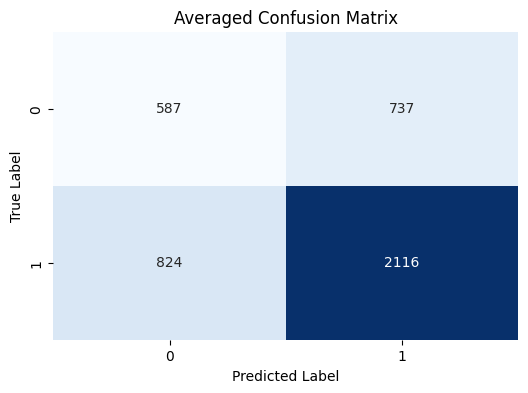

In [15]:

# Calculate the average confusion matrix across all folds
conf_matrix_avg = np.mean(confusion_matrices, axis=0).astype(int)

# Plot the averaged confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_avg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Averaged Confusion Matrix')
plt.show()



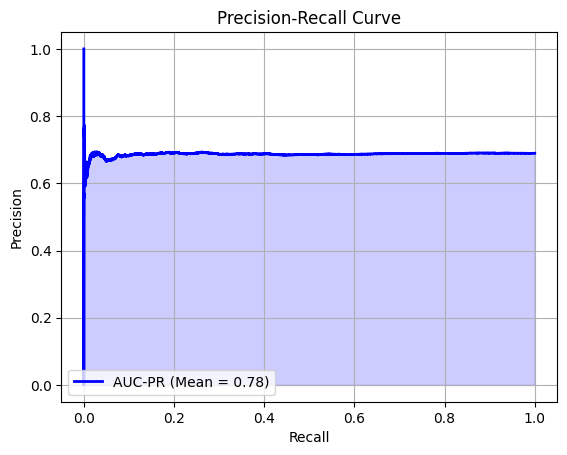

In [16]:

# Plot the precision-recall curve
plt.plot(recall, precision, color='b', lw=2, label=f'AUC-PR (Mean = {mean_auc_pr:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

In [ ]:
model_filename = '/content/drive/MyDrive/epro_project_data/classification_models/xgb_encoder_model_v1.pkl'
joblib.dump(logreg_model, model_filename)


## Model 3: Creating an Ensemble with 7 Different Classifier

In [17]:
# Initialize classifiers
classifier1 = DecisionTreeClassifier(random_state=42, class_weight='balanced')
classifier2 = RandomForestClassifier(random_state=42, class_weight='balanced')
classifier3 = GradientBoostingClassifier(random_state=42)
classifier4 = SVC(random_state=42, class_weight='balanced', probability=True)
classifier5 = KNeighborsClassifier(n_neighbors=6)
classifier6 = LogisticRegression(random_state=42, class_weight='balanced')
classifier7 = GaussianNB()

classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5, classifier6, classifier7]

In [18]:
auc_pr_scores = []
confusion_matrices = []

for clf in classifiers:
    cv_scores = []
    y_probas_all_folds = []

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        clf.fit(X_train, y_train)
        y_probas = clf.predict_proba(X_test)[:, 1]

        # Append predicted probabilities for this fold to the list
        y_probas_all_folds.extend(y_probas)

        cv_scores.append(average_precision_score(y_test, y_probas))
        y_pred = clf.predict(X_test)
        confusion_matrices.append(confusion_matrix(y_test, y_pred))

    # Calculate the mean AUC-PR score across all folds
    mean_auc_pr = np.mean(cv_scores)
    auc_pr_scores.append(mean_auc_pr)

    # Find the best threshold that maximizes the mean AUC-PR score
    precision, recall, thresholds = precision_recall_curve(y, y_probas_all_folds)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print(f"Classifier: {clf.__class__.__name__}")
    print(f"Best Threshold: {best_threshold:.4f}")
    print(f"Mean AUC-PR: {mean_auc_pr:.4f}")

Classifier: DecisionTreeClassifier
Best Threshold: 0.0000
Mean AUC-PR: 0.7094
Classifier: RandomForestClassifier
Best Threshold: 0.0200
Mean AUC-PR: 0.7691
Classifier: GradientBoostingClassifier
Best Threshold: 0.3149
Mean AUC-PR: 0.7511
Classifier: SVC
Best Threshold: 0.5269
Mean AUC-PR: 0.7531
Classifier: KNeighborsClassifier
Best Threshold: 0.0000
Mean AUC-PR: 0.7393
Classifier: LogisticRegression
Best Threshold: 0.3289
Mean AUC-PR: 0.7276
Classifier: GaussianNB
Best Threshold: 0.2522
Mean AUC-PR: 0.7153


In [20]:
auc_pr_ensemble=cv_scores

In [19]:
results_df = pd.DataFrame({
    'Classifier': [clf.__class__.__name__ for clf in classifiers],
    'AUC-PR Score': auc_pr_scores,
    'Confusion Matrix': [np.mean(confusion_matrices, axis=0).astype(int) for _ in classifiers]
})

# Format the Confusion Matrix as a string for tabulation
results_df['Confusion Matrix'] = results_df['Confusion Matrix'].apply(lambda x: '\n'.join([' '.join(map(str, row)) for row in x]))

In [21]:
print(tabulate(results_df, headers='keys', tablefmt='grid', showindex=False))

+----------------------------+----------------+--------------------+
| Classifier                 |   AUC-PR Score | Confusion Matrix   |
+============================+================+====================+
| DecisionTreeClassifier     |       0.709403 | 386 938            |
|                            |                | 645 2295           |
+----------------------------+----------------+--------------------+
| RandomForestClassifier     |       0.769118 | 386 938            |
|                            |                | 645 2295           |
+----------------------------+----------------+--------------------+
| GradientBoostingClassifier |       0.751144 | 386 938            |
|                            |                | 645 2295           |
+----------------------------+----------------+--------------------+
| SVC                        |       0.753125 | 386 938            |
|                            |                | 645 2295           |
+----------------------------+----

In [22]:
mean_confusion_matrices=[np.mean(confusion_matrices, axis=0).astype(int) for _ in classifiers]

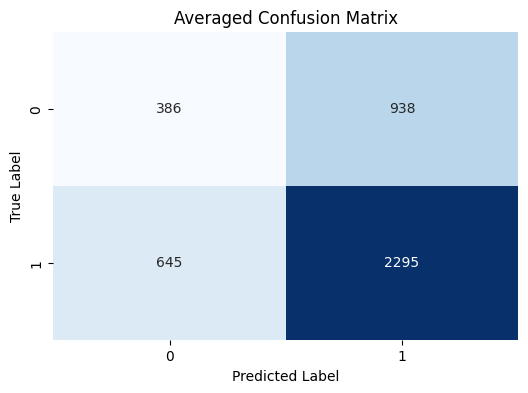

In [23]:
# Plot the averaged confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(mean_confusion_matrices[-1]), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Averaged Confusion Matrix')
plt.show()

In [ ]:
model_filename = '/content/drive/MyDrive/epro_project_data/classification_models/ensemble_encoder_model_v1.pkl'
joblib.dump(classifiers, model_filename)

In [24]:
classifiers

[DecisionTreeClassifier(class_weight='balanced', random_state=42),
 RandomForestClassifier(class_weight='balanced', random_state=42),
 GradientBoostingClassifier(random_state=42),
 SVC(class_weight='balanced', probability=True, random_state=42),
 KNeighborsClassifier(n_neighbors=6),
 LogisticRegression(class_weight='balanced', random_state=42),
 GaussianNB()]

## Comparing the Performance of all the Models

In [25]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

# Create random data for the three models and the metrics
models = ['Logistic', 'XGBoost', 'Ensemble']
metrics = ['AUC-PR', 'Precision', 'Recall', ]

data = np.array([[0.7276, 0.72, 0.59], [0.7768, 0.74, 0.72], [0.7391, 0.70, 0.78]])

# Create the bar chart using Plotly
fig = go.Figure()

for i, model in enumerate(models):
    fig.add_trace(go.Bar(
        x=metrics,
        y=data[i],
        name=model,
        marker=dict(color=px.colors.qualitative.Plotly[i])
    ))

# Update layout to make the chart look prettier
fig.update_layout(
    title='Model Comparison with Metrics',
    xaxis_title='Metrics',
    yaxis_title='Values',
    barmode='group',
    bargap=0.2,
    bargroupgap=0.1,
    showlegend=True,
    legend=dict(x=0.4, y=1.1, orientation='h')
)

# Show the plot
fig.show()


In [26]:
from scipy.stats import ranksums

In [59]:

# AUC PR scores for each model
auc_pr_logreg_arr = np.array(auc_pr_logreg)
auc_pr_xgboost_arr = np.array(auc_pr_xgboost)
auc_pr_ensemble_arr = np.array(auc_pr_ensemble)

In [28]:
import numpy as np
from scipy.stats import ranksums


# Perform Wilcoxon Rank-Sum Test between pairs of models
statistic_logreg_xgboost, p_value_logreg_xgboost = ranksums(auc_pr_logreg_arr, auc_pr_xgboost_arr)
statistic_logreg_svm, p_value_logreg_svm = ranksums(auc_pr_logreg_arr, auc_pr_ensemble_arr)
statistic_xgboost_svm, p_value_xgboost_svm = ranksums(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Print the results
print("Wilcoxon Rank-Sum Test (Mann-Whitney U) Results:")
print("Logistic Regression vs XGBoost:")
print("Statistic:", statistic_logreg_xgboost)
print("p-value:", p_value_logreg_xgboost)
print()

print("Logistic Regression vs Ensemble:")
print("Statistic:", statistic_logreg_svm)
print("p-value:", p_value_logreg_svm)
print()

print("XGBoost vs Ensemble:")
print("Statistic:", statistic_xgboost_svm)
print("p-value:", p_value_xgboost_svm)


Wilcoxon Rank-Sum Test (Mann-Whitney U) Results:
Logistic Regression vs XGBoost:
Statistic: -2.6111648393354674
p-value: 0.009023438818080326

Logistic Regression vs Ensemble:
Statistic: 2.1933784650417927
p-value: 0.028280122568276955

XGBoost vs Ensemble:
Statistic: 2.6111648393354674
p-value: 0.009023438818080326


In [70]:
import numpy as np
from scipy.stats import wilcoxon

# Perform Wilcoxon Signed-Rank Test between pairs of models
statistic_logreg_xgboost, p_value_logreg_xgboost = wilcoxon(auc_pr_logreg_arr, auc_pr_xgboost_arr)
statistic_logreg_ensemble, p_value_logreg_ensemble = wilcoxon(auc_pr_logreg_arr, auc_pr_ensemble_arr)
statistic_xgboost_ensemble, p_value_xgboost_ensemble = wilcoxon(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Print the results
print("Wilcoxon Signed-Rank Test Results:")
print("Logistic Regression vs XGBoost:")
print("p-value:", p_value_logreg_xgboost)
if p_value_logreg_xgboost <= 0.05:
    print("There is a statistically significant difference.")
else:
    print("There is no statistically significant difference.")
print()

print("Logistic Regression vs Ensemble:")
print("p-value:", p_value_logreg_ensemble)
if p_value_logreg_ensemble <= 0.05:
    print("There is a statistically significant difference.")
else:
    print("There is no statistically significant difference.")
print()

print("XGBoost vs Ensemble:")
print("p-value:", p_value_xgboost_ensemble)
if p_value_xgboost_ensemble <= 0.05:
    print("There is a statistically significant difference.")
else:
    print("There is no statistically significant difference.")


Wilcoxon Signed-Rank Test Results:
Logistic Regression vs XGBoost:
p-value: 0.0625
There is no statistically significant difference.

Logistic Regression vs Ensemble:
p-value: 0.0625
There is no statistically significant difference.

XGBoost vs Ensemble:
p-value: 0.0625
There is no statistically significant difference.


In [69]:
import numpy as np
from scipy.stats import wilcoxon

# Perform Wilcoxon Signed-Rank Test between pairs of models
statistic_logreg_xgboost, p_value_logreg_xgboost = wilcoxon(auc_pr_logreg_arr, auc_pr_xgboost_arr)
statistic_logreg_ensemble, p_value_logreg_ensemble = wilcoxon(auc_pr_logreg_arr, auc_pr_ensemble_arr)
statistic_xgboost_ensemble, p_value_xgboost_ensemble = wilcoxon(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Print the results
print("Wilcoxon Signed-Rank Test Results:")
print("Logistic Regression vs XGBoost:")
print("Statistic:", statistic_logreg_xgboost)
print("p-value:", p_value_logreg_xgboost)
print()

print("Logistic Regression vs Ensemble:")
print("Statistic:", statistic_logreg_ensemble)
print("p-value:", p_value_logreg_ensemble)
print()

print("XGBoost vs Ensemble:")
print("Statistic:", statistic_xgboost_ensemble)
print("p-value:", p_value_xgboost_ensemble)


Wilcoxon Signed-Rank Test Results:
Logistic Regression vs XGBoost:
Statistic: 0.0
p-value: 0.0625

Logistic Regression vs Ensemble:
Statistic: 0.0
p-value: 0.0625

XGBoost vs Ensemble:
Statistic: 0.0
p-value: 0.0625


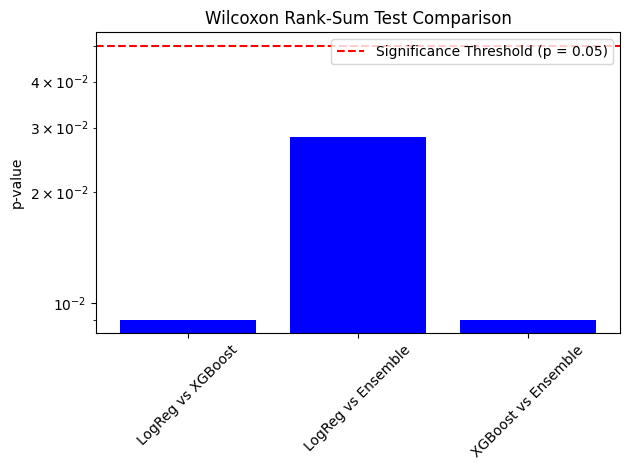

In [29]:
# Perform Wilcoxon Rank-Sum Test between pairs of models
_, p_value_logreg_xgboost = ranksums(auc_pr_logreg_arr, auc_pr_xgboost_arr)
_, p_value_logreg_ensemble = ranksums(auc_pr_logreg_arr, auc_pr_ensemble_arr)
_, p_value_xgboost_ensemble = ranksums(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Create a bar plot of p-values
models = ['LogReg vs XGBoost', 'LogReg vs Ensemble', 'XGBoost vs Ensemble']
p_values = [p_value_logreg_xgboost, p_value_logreg_ensemble, p_value_xgboost_ensemble]

plt.bar(models, p_values, color=np.where(np.array(p_values) < 0.05, 'blue', 'gray'))
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Threshold (p = 0.05)')
plt.ylabel('p-value')
plt.title('Wilcoxon Rank-Sum Test Comparison')
plt.yscale('log')  # Use log scale for better visualization of small p-values
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

In [30]:
import numpy as np
import plotly.express as px
from scipy.stats import ranksums


# Perform Wilcoxon Rank-Sum Test between pairs of models
_, p_value_logreg_xgboost = ranksums(auc_pr_logreg_arr, auc_pr_xgboost_arr)
_, p_value_logreg_ensemble = ranksums(auc_pr_logreg_arr, auc_pr_ensemble_arr)
_, p_value_xgboost_ensemble = ranksums(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Create a Plotly bar plot
models = ['LogReg vs XGBoost', 'LogReg vs Ensemble', 'XGBoost vs Ensemble']
p_values = [p_value_logreg_xgboost, p_value_logreg_ensemble, p_value_xgboost_ensemble]
significant = ['Significant' if p < 0.05 else 'Non-Significant' for p in p_values]

data = {
    'Models': models,
    'p-values': p_values,
    'Significance': significant
}

fig = px.bar(data, x='Models', y='p-values', color='Significance', color_discrete_map={'Significant': 'blue', 'Non-Significant': 'gray'})

# Add vertical line at p-value 0.05
fig.add_shape(
    type='line',
    x0=-0.5,
    y0=0.05,
    x1=2.5,
    y1=0.05,
    line=dict(color='red', dash='dash')
)

fig.update_layout(
    title='Wilcoxon Rank-Sum Test Comparison',
    yaxis_title='p-value',
    xaxis_tickangle=-45,
    legend_title='Significance',
    barmode='group'
)

fig.show()


In [31]:
import numpy as np
import plotly.express as px
from scipy.stats import ranksums


# Perform Wilcoxon Rank-Sum Test between pairs of models
_, p_value_logreg_xgboost = ranksums(auc_pr_logreg_arr, auc_pr_xgboost_arr)
_, p_value_logreg_ensemble = ranksums(auc_pr_logreg_arr, auc_pr_ensemble_arr)
_, p_value_xgboost_ensemble = ranksums(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Create a Plotly bar plot
models = ['LogReg vs XGBoost', 'LogReg vs Ensemble', 'XGBoost vs Ensemble']
p_values = [p_value_logreg_xgboost, p_value_logreg_ensemble, p_value_xgboost_ensemble]

data = {
    'Models': models,
    'p-values': p_values,
    'Significance': ['Significant' if p < 0.05 else 'Non-Significant' for p in p_values]
}

fig = px.bar(data, x='Models', y='p-values', color='Significance',
             color_discrete_map={'Significant': '#008080', 'Non-Significant': 'gray'})

# Add vertical line at p-value 0.05
fig.add_shape(
    type='line',
    x0=-0.5,
    y0=0.05,
    x1=2.5,
    y1=0.05,
    line=dict(color='red', dash='dash')
)

fig.update_layout(
    title='Wilcoxon Rank-Sum Test Comparison',
    yaxis_title='p-value',
    xaxis_tickangle=-45,
    legend_title='Significance',
    barmode='group'
)

fig.show()


In [32]:
import numpy as np
from scipy.stats import f_oneway

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Print the ANOVA results
print("One-Way ANOVA Results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: At least one model has a different mean AUC PR.")
else:
    print("Fail to reject the null hypothesis: The means of AUC PR scores are not significantly different.")


One-Way ANOVA Results:
F-statistic: 122.81192773131373
p-value: 1.0213416063280388e-08
Reject the null hypothesis: At least one model has a different mean AUC PR.


In [44]:
import numpy as np
import plotly.express as px
from scipy.stats import f_oneway



# Perform one-way ANOVA
f_statistic, p_value = f_oneway(auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Create a Plotly bar plot
data = {
    'Model': ['Logistic Regression', 'XGBoost', 'Ensemble'],
    'AUC PR': [auc_pr_logreg_arr.mean(), auc_pr_xgboost_arr.mean(), auc_pr_ensemble_arr.mean()]
}

fig = px.bar(data, x='Model', y='AUC PR', text='AUC PR', labels={'AUC PR': 'Mean AUC PR'})

# Add ANOVA results to the plot title
fig.update_layout(
    title=f'Comparison of Mean AUC PR (One-Way ANOVA)\nF-statistic: {f_statistic:.2f}, p-value: {p_value:.9f}',
    yaxis_title='Mean AUC PR',
    xaxis_title='Model',
    xaxis_tickangle=-45
)

fig.show()


In [ ]:
# AUC PR scores for each model
auc_pr_logreg_arr
auc_pr_xgboost_arr
auc_pr_ensemble_arr

In [51]:
from scipy.stats import shapiro

# Example data (replace with your data)
data = auc_pr_ensemble_arr

# Perform Shapiro-Wilk test
statistic, p_value = shapiro(data)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Data does not follow a normal distribution.")
else:
    print("Data appears to follow a normal distribution.")


Data appears to follow a normal distribution.


In [60]:
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison

# Combine all scores for the post hoc test
all_scores = np.concatenate([auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr])

# Create labels for each group
labels = ['Logistic Regression'] * len(auc_pr_logreg_arr) + ['XGBoost'] * len(auc_pr_xgboost_arr) + ['Ensemble'] * len(auc_pr_ensemble_arr)

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Perform Tukey's HSD post hoc test
posthoc = MultiComparison(all_scores, labels)
result = posthoc.tukeyhsd()

# Print the ANOVA results
print("One-Way ANOVA Results:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

# Print the Tukey HSD results
print("Tukey HSD Results:")
print(result)

# Interpret the Tukey HSD results
significant_pairs = np.where(result.reject)
print("Significant pairwise comparisons:", result.pairwise_tukeyhsd.reject[significant_pairs])


One-Way ANOVA Results:
F-statistic: 122.81192773131373
p-value: 1.0213416063280388e-08
Tukey HSD Results:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj  lower  upper  reject
----------------------------------------------------------------------------
           Ensemble Logistic Regression   0.0122 0.0304 0.0012 0.0233   True
           Ensemble             XGBoost   0.0615    0.0 0.0504 0.0726   True
Logistic Regression             XGBoost   0.0493    0.0 0.0382 0.0603   True
----------------------------------------------------------------------------


AttributeError: ignored

Paired t-test Results:
Logistic Regression vs. XGBoost: p-value = 0.0004
Statistically significant difference (Reject null hypothesis)

Logistic Regression vs. Ensemble: p-value = 0.0213
Statistically significant difference (Reject null hypothesis)

XGBoost vs. Ensemble: p-value = 0.0003
Statistically significant difference (Reject null hypothesis)



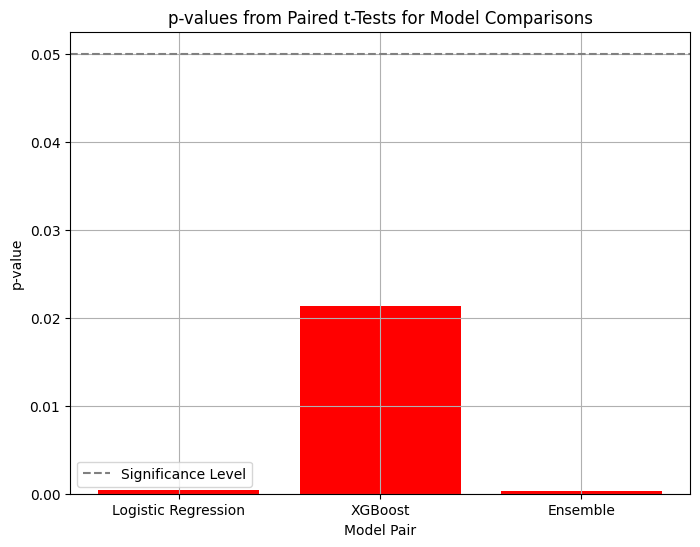

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Perform paired t-tests for each pair of models
t_stat_logreg_xgboost, p_value_logreg_xgboost = ttest_rel(auc_pr_logreg_arr, auc_pr_xgboost_arr)
t_stat_logreg_ensemble, p_value_logreg_ensemble = ttest_rel(auc_pr_logreg_arr, auc_pr_ensemble_arr)
t_stat_xgboost_ensemble, p_value_xgboost_ensemble = ttest_rel(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Set the significance level
alpha = 0.05

# Print p-values and interpret the results for each pair
print("Paired t-test Results:")
print(f"Logistic Regression vs. XGBoost: p-value = {p_value_logreg_xgboost:.4f}")
if p_value_logreg_xgboost < alpha:
    print("Statistically significant difference (Reject null hypothesis)\n")
else:
    print("No statistically significant difference (Fail to reject null hypothesis)\n")

print(f"Logistic Regression vs. Ensemble: p-value = {p_value_logreg_ensemble:.4f}")
if p_value_logreg_ensemble < alpha:
    print("Statistically significant difference (Reject null hypothesis)\n")
else:
    print("No statistically significant difference (Fail to reject null hypothesis)\n")

print(f"XGBoost vs. Ensemble: p-value = {p_value_xgboost_ensemble:.4f}")
if p_value_xgboost_ensemble < alpha:
    print("Statistically significant difference (Reject null hypothesis)\n")
else:
    print("No statistically significant difference (Fail to reject null hypothesis)\n")

# Create a bar plot to visualize the p-values
p_values = [p_value_logreg_xgboost, p_value_logreg_ensemble, p_value_xgboost_ensemble]
significant = [p < alpha for p in p_values]
colors = ['red' if s else 'blue' for s in significant]

plt.figure(figsize=(8, 6))
plt.bar(models, p_values, color=colors)
plt.xlabel('Model Pair')
plt.ylabel('p-value')
plt.title('p-values from Paired t-Tests for Model Comparisons')
plt.axhline(y=alpha, color='gray', linestyle='dashed', label='Significance Level')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
pip install tabulate

+----------------------------------+-------------+----------------+
| Model Pair                       |     p-value | Significance   |
+==================================+=============+================+
| Logistic Regression vs. XGBoost  | 0.00037604  | Yes            |
+----------------------------------+-------------+----------------+
| Logistic Regression vs. Ensemble | 0.0212959   | Yes            |
+----------------------------------+-------------+----------------+
| XGBoost vs. Ensemble             | 0.000266402 | Yes            |
+----------------------------------+-------------+----------------+


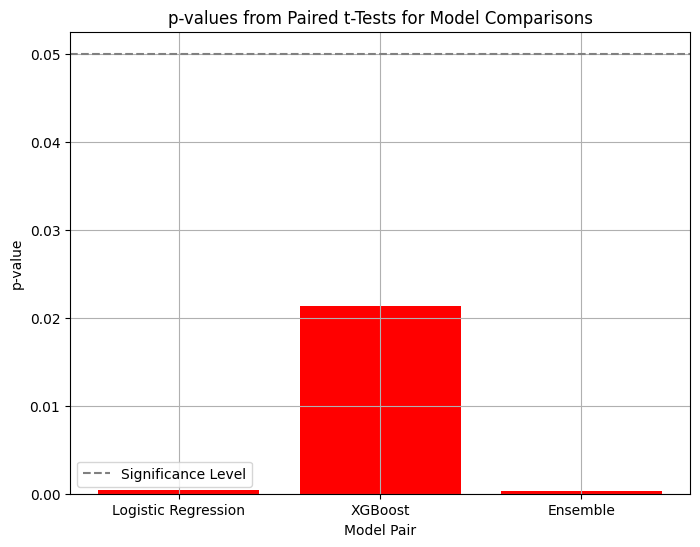

In [66]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from tabulate import tabulate

# Perform paired t-tests for each pair of models
t_stat_logreg_xgboost, p_value_logreg_xgboost = ttest_rel(auc_pr_logreg_arr, auc_pr_xgboost_arr)
t_stat_logreg_ensemble, p_value_logreg_ensemble = ttest_rel(auc_pr_logreg_arr, auc_pr_ensemble_arr)
t_stat_xgboost_ensemble, p_value_xgboost_ensemble = ttest_rel(auc_pr_xgboost_arr, auc_pr_ensemble_arr)

# Create a table to display the results
table = [
    ["Model Pair", "p-value", "Significance"],
    ["Logistic Regression vs. XGBoost", p_value_logreg_xgboost, "Yes" if p_value_logreg_xgboost < 0.05 else "No"],
    ["Logistic Regression vs. Ensemble", p_value_logreg_ensemble, "Yes" if p_value_logreg_ensemble < 0.05 else "No"],
    ["XGBoost vs. Ensemble", p_value_xgboost_ensemble, "Yes" if p_value_xgboost_ensemble < 0.05 else "No"]
]

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

# Create a bar plot to visualize the p-values
p_values = [p_value_logreg_xgboost, p_value_logreg_ensemble, p_value_xgboost_ensemble]
significant = [p < 0.05 for p in p_values]
colors = ['red' if s else 'blue' for s in significant]

plt.figure(figsize=(8, 6))
plt.bar(models, p_values, color=colors)
plt.xlabel('Model Pair')
plt.ylabel('p-value')
plt.title('p-values from Paired t-Tests for Model Comparisons')
plt.axhline(y=0.05, color='gray', linestyle='dashed', label='Significance Level')
plt.legend()
plt.grid(True)
plt.show()


In [71]:
import numpy as np
from scipy.stats import kruskal

# Combine performance data for all models
all_performance_data = [auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*all_performance_data)

# Print the results
print("Kruskal-Wallis Test Results:")
print("Statistic:", statistic)
print("p-value:", p_value)

if p_value <= 0.05:
    print("There is a statistically significant difference among model performances.")
else:
    print("There is no statistically significant difference among model performances.")


Kruskal-Wallis Test Results:
Statistic: 11.579999999999998
p-value: 0.0030579821764233103
There is a statistically significant difference among model performances.


In [77]:
import numpy as np
from scipy.stats import kruskal
from tabulate import tabulate

# Combine performance data for all models
all_performance_data = [auc_pr_logreg_arr, auc_pr_xgboost_arr, auc_pr_ensemble_arr]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*all_performance_data)

# Create a table
table = [["Kruskal-Wallis Test", "Statistic", statistic],
         ["", "p-value", p_value],
         ["", "Conclusion", "There is a statistically significant difference among model performances" if p_value <= 0.05 else "Not Significant"]]

# Print the table
table_str = tabulate(table, headers=["Test", "Metric", "Value"], tablefmt="grid")
print(table_str)


+---------------------+------------+--------------------------------------------------------------------------+
| Test                | Metric     | Value                                                                    |
+=====================+============+==========================================================================+
| Kruskal-Wallis Test | Statistic  | 11.579999999999998                                                       |
+---------------------+------------+--------------------------------------------------------------------------+
|                     | p-value    | 0.0030579821764233103                                                    |
+---------------------+------------+--------------------------------------------------------------------------+
|                     | Conclusion | There is a statistically significant difference among model performances |
+---------------------+------------+--------------------------------------------------------------------

## Robustness Testing and Performance on Cold Start Scenarios

In [ ]:
encoded_data_directory = '/content/drive/MyDrive/epro_project_data/new_test_data'

In [ ]:
test_data=pd.read_csv('/content/drive/MyDrive/epro_project_data/new_test_data/large_new_test.csv')

In [ ]:
X = test_data.drop(columns=['researchParticipantId', 'class'])
y = test_data['class']

In [ ]:
test_data

In [ ]:
y.value_counts()

In [ ]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, precision_recall_curve, f1_score

# Load the XGBoost model from the file
model_filename = '/content/drive/MyDrive/epro_project_data/classification_models/xgb_encoder_model_v1.pkl'
loaded_model = joblib.load(model_filename)

# Assuming you have X_test as your test dataset and y_test as the true labels for the test dataset
X_test =test_data.drop(columns=['researchParticipantId', 'class'])
y_test = test_data['class']

# Get predicted probabilities of positive class (class 1)
y_pred_prob = loaded_model.predict_proba(X_test)[:, 1]

# Find the best threshold that maximizes F1-score
thresholds = np.linspace(0, 1, 1000)
f1_scores = []
for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

best_threshold = thresholds[np.argmax(f1_scores)]




In [ ]:
# Set the best threshold for predictions
y_pred = (y_pred_prob >= 0.91).astype(int)

# Compute classification metrics with the best threshold
print("Classification Report with Best Threshold:")
print(classification_report(y_test, y_pred))
classification_rep=classification_report(y_test, y_pred,output_dict=True)
print("Confusion Matrix with Best Threshold:")
print(confusion_matrix(y_test, y_pred))
conf_matrix=confusion_matrix(y_test, y_pred)
# Compute AUC-PR Score with the best threshold
best_auc_pr_score = average_precision_score(y_test, y_pred_prob >= best_threshold)
print("AUC-PR Score with Best Threshold:", best_auc_pr_score)

# Plot the Precision-Recall Curve with the best threshold
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold')
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute AUC-PR Score with the best threshold
best_auc_pr_score = average_precision_score(y_test, y_pred_prob >= best_threshold)
print("AUC-PR Score with Best Threshold:", best_auc_pr_score)

# Plot the Precision-Recall Curve with the best threshold
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Best Threshold')
plt.show()

In [ ]:
best_auc_pr_score = average_precision_score(y_test, y_pred_prob >= best_threshold)

# Prepare the data for tabulating
data = {'Metric': ['AUC-PR Score', 'Precision', 'Recall', 'F1-Score', 'Support'],
        'Positive Class': [best_auc_pr_score,
                           classification_rep['1']['precision'],
                           classification_rep['1']['recall'],
                           classification_rep['1']['f1-score'],
                           classification_rep['1']['support']],
        'Negative Class': [None,
                           classification_rep['0']['precision'],
                           classification_rep['0']['recall'],
                           classification_rep['0']['f1-score'],
                           classification_rep['0']['support']]}

# Display the classification metrics using tabulate
print(tabulate(data, headers='keys', tablefmt='grid'))